# ◆Forex forecast USD／JPY
### Based on USD / JPY daily forecast, we predict whether the closing price of the next day will rise or fall.
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【table of contents】

- 0.[**Import module**](#Import_module)
- 1.[**Import data**](#Import_data)
- 2.[**Feature engineering**](#Future_engineering)
- 3.[**Data visualization**](#Data_visualization)
- 4.[**Setting the objective variable**](#Setting_the_objective_variable)
- 5.[**Preprocessing**](#Preprocessing)
- 6.[**Modeling**](#Modeling)

#### ※usdjpy_d.csv

| No | Column | ColumnName | Missing | use |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0. Import module<a id='Import_module'></a>

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

# ****************************************************************************
# setting
# ****************************************************************************
train_size = 0.80

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# ============================================================================
# plot_learning_curve
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# get_tilt
# ============================================================================
def get_tilt(close):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length):
        if i < 1:
            tilt[i] = 0
        else :
            a = pd.Series(close)[i:i+1].values - pd.Series(close)[i-1:i].values
            tilt[i] = a/1
    return tilt

# ============================================================================
# get_rsi
# ============================================================================
def get_rsi(close, period):
    
    diff = close.diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    up_sma = up.rolling(window=period, center=False).mean()
    down_sma = down.abs().rolling(window=period, center=False).mean()
    
    rs = up_sma / down_sma
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

# ============================================================================
# get_rci
# ============================================================================
def get_rci(close, period):
    rank_period = np.arange(period, 0, -1)
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        if i < period - 1:
            rci[i] = 0
        else :
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            rci[i] = np.int32((1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100)
            
    return rci

# ============================================================================
# get_bb
# ============================================================================
def get_bb(close, sigma):
    mean = close.rolling(window=21).mean()
    std = close.rolling(window=21).std()
    upper = mean + (std * sigma)
    lower = mean - (std * sigma)
    return upper,lower

# ============================================================================
# get_momentum
# ============================================================================
def get_momentum(close, period):
    return close - close.shift(period)

# ============================================================================
# get_sma
# ============================================================================
def get_sma(close, period):
    return list(pd.Series(close).rolling(period).mean())

# ============================================================================
# get_ema
# ============================================================================
def get_ema(close, period):
    return list(pd.Series(close).ewm(span=period).mean())

# 1. Import data<a id='Import_data'></a>

In [2]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

now = datetime.datetime.today()
today = now.strftime("%Y-%m-%d 00:00:00")

# ********* Enter today *********
open = 109.837
high = 109.853
low = 109.490
close = 109.523
# *******************************

tmp_se = pd.Series([today,open,high,low,close], index=df.columns)    
df = df.append(tmp_se, ignore_index=True)

printmd('▼ Last 3 lines display')
display(df.tail(3))

# column name change
df.rename(columns={'Date' : 'time'}, inplace=True)
df.rename(columns={'Open' : 'open'}, inplace=True)
df.rename(columns={'High' : 'high'}, inplace=True)
df.rename(columns={'Low' : 'low'}, inplace=True)
df.rename(columns={'Close' : 'close'}, inplace=True)

df['time'] = pd.to_datetime(df['time'])
#print(df.dtypes)

# calc target
df = df.query('time >= "2017-01-01"')



**▼ Last 3 lines display**

,Date,Open,High,Low,Close
12543,2020-01-21 00:00:00,110.175,110.222,109.764,109.856
12544,2020-01-22 00:00:00,109.857,110.089,109.808,109.828
12545,2020-01-23 00:00:00,109.837,109.853,109.490,109.523


# 2. Feature engineering <a id ='Future_engineering'></a>

In [3]:
# sma/ema
df['sma5']= get_sma(df.close,5)
df['sma21']= get_sma(df.close,21)
df['ema10']= get_ema(df.close,10)

# tilt(sma/ema)
df['tilt_sma5']= get_tilt(df.sma5)
df['tilt_sma21']= get_tilt(df.sma21)
df['tilt_ema10']= get_tilt(df.ema10)

# BB
df['bb1_up'], df['bb1_low'] = get_bb(df.close, 2)
df['bb2_up'], df['bb2_low'] = get_bb(df.close, 2)
df['bb3_up'], df['bb3_low'] = get_bb(df.close, 2)

# Bollinger band contraction
df['bb1_shrinkage'] = df['bb1_up'] - df['bb1_low']
df['bb2_shrinkage'] = df['bb2_up'] - df['bb2_low']
df['bb3_shrinkage'] = df['bb3_up'] - df['bb3_low']

# momentum
df['momentum_5'] = get_momentum(df.close, 5)
df['momentum_10'] = get_momentum(df.close, 10)
df['momentum_21'] = get_momentum(df.close, 21)

# RCI
df['rci9'] = get_rci(df.close,9)
df['rci21'] = get_rci(df.close,21)
df['rci52'] = get_rci(df.close,52)

# tilt(RCI)
df['tilt_rci9'] = get_tilt(df.rci9)
df['tilt_rci21'] = get_tilt(df.rci21)
df['tilt_rci52'] = get_tilt(df.rci52)

# RSI
df['rsi14'] = get_rsi(df.close,14)
df['tilt_rsi14'] = get_tilt(df.rsi14)

# Candlestick features
df['day_chg'] = df.close - df.open # Daily change
df['c_up'] = np.where(df.day_chg >= 0,1,0) # 陽線：1／陰線：0
df['c_all_len'] = abs(df.high - df.low) # Candle length(ヒゲ含む)
df['c_pil_len'] = np.where(df.day_chg >= 0,df.close - df.open,df.open - df.close) # Candle length
df['top_bar'] = np.where(df.day_chg >= 0,df.high - df.close, df.high - df.open) # 上ヒゲの長さ
df['low_bar'] = np.where(df.day_chg >= 0,df.open - df.low, df.close - df.low)   # 下ヒゲの長さ

# https://east-fx.com/archives/553
dic_c = {'c_y_b':'陽の丸坊主',
         'c_y_dai':'大陽線',
         'c_y_h_b':'陽の大引け坊主',
         'c_y_y_b':'陽の寄り付き坊主',
         'c_y_sg':'下影陽線',
         'c_y_ug':'上影陽線',
         'c_y_km':'陽のコマ',
         'c_y_kk':'陽のカラカサ',
         'c_i_b':'陰の丸坊主',
         'c_i_dai':'大陰線',
         'c_i_y_b':'陰の寄り付き坊主',
         'c_i_h_i':'陰の大引け陰線',
         'c_i_sg':'下影陰線',
         'c_i_km':'陰のコマ',
         'c_i_ug':'上影陰線',
         'c_i_kk':'陰のカラカサ',
         'c_juji':'十字',
         'c_tonbo':'トンボ',
         'c_touba':'トウバ',
         'c_ippon':'一本線'
         }

# 陽の丸坊主(ヒゲがなく実体が長い陽線。買い勢力がかなり強い形)
df['c_y_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陽線(上下ヒゲはあるが実体が長い陽線。買い勢力がかなり強い形。)
df['c_y_dai'] = np.where((df.c_up == 1) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陽の大引け坊主(上ヒゲがなく、下ヒゲがある。買いの勢いがまだまだ強い形。)
df['c_y_h_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陽の寄り付き坊主(上ヒゲのみの陽線。買い勢力が強いが、上ヒゲが長すぎると天井になる可能性もある形。)
df['c_y_y_b'] = np.where((df.c_up == 1) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陽線(実体よりも下ヒゲが長い形。一旦売り勢力に攻め込まれてからの戻しの長いヒゲなので、買い勢力が強い。)
df['c_y_sg'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 上影陽線(実体よりも上ヒゲが長い形。買い勢力が売り勢力に押され気味になり上ヒゲになるので、買い勢力が若干弱め。実体が短すぎ場合はトレンド転換の可能性あり。)
df['c_y_ug'] = np.where((df.c_up == 1) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陽のコマ(保ち合い。売り買いの勢力が拮抗している状態で現れる。陽線の場合は強持ち合いと呼ばれる。トレンド転換の可能性あり。)
df['c_y_km'] = np.where((df.c_up == 1) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.20), 1 , 0)
# 陽のカラカサ(下ヒゲが長く、実体がヒゲよりも小さい形。トレンド転換する可能性あり。)
df['c_y_kk'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 陰の丸坊主(ヒゲがなく実体が長い陰線。売り勢力がかなり強い形)
df['c_i_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陰線(上下ヒゲはあるが実体が長い陰線。売り勢力がかなり強い形。)
df['c_i_dai'] = np.where((df.c_up == 0) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陰の寄り付き坊主(上ヒゲがない陰線。実体部分が長いので売り勢力優勢ではあるが、下ヒゲが長すぎるとトレンド転換の可能性あり。)
df['c_i_y_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陰の大引け陰線(下ヒゲがない形。実体部分が長く売り勢力の勢いも強い。)
df['c_i_h_i'] = np.where((df.c_up == 0) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陰線(下ヒゲが長く実体がヒゲよりも短い陰線。売りの勢力が少し弱まっている際に出現しやすいので、トレンド転換する可能性あり。)
df['c_i_sg'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 陰のコマ(売り・買い勢力が拮抗している形。陰線の場合は弱持合いと呼ばれている。)
df['c_i_km'] = np.where((df.c_up == 0) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.2), 1 , 0)
# 上影陰線(上ヒゲが長く実体がヒゲより短い形。一旦買い勢力に押し戻されてから再度ヒゲをつけて戻しているので、売り勢力が強い。ただ、実体が短すぎるとトレンド転換の可能性もある。)
df['c_i_ug'] = np.where((df.c_up == 0) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陰のカラカサ(下ヒゲが長く上ヒゲがなく、且つ実体が短い形。)
df['c_i_kk'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 十字（天井もしくは底ならトレンド転換の可能性あり。）
df['c_juji'] = np.where((df.c_pil_len < 0.1) & (abs(df.top_bar - df.low_bar) <= 0.1) & (df.c_pil_len < 0.1), 1 , 0)
# トンボ（天井もしくは底ならトレンド転換の可能性あり。）
df['c_tonbo'] = np.where((df.top_bar < 0.05) & (df.low_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# トウバ(天井もしくは底ならトレンド転換の可能性あり。)
df['c_touba'] = np.where((df.low_bar < 0.05) & (df.top_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# 一本線(継続トレンド転換の可能性あり)
df['c_ippon'] = np.where((df.low_bar < 0.05) & (df.top_bar < 0.05) & (df.c_pil_len < 0.1), 1 , 0)

# Candlestick features for the last few days
df['y1_day_chg'] = df.day_chg.shift(+1)
df['y1_c_all_len'] = df.c_all_len.shift(+1)
df['y1_c_pil_len'] = df.c_pil_len.shift(+1)
df['y1_c_up'] = df.c_up.shift(+1)
df['y1_top_bar'] = df.top_bar.shift(+1)
df['y1_low_bar'] = df.low_bar.shift(+1)

df['y2_day_chg'] = df.day_chg.shift(+2)
df['y2_c_all_len'] = df.c_all_len.shift(+2)
df['y2_c_pil_len'] = df.c_pil_len.shift(+2)
df['y2_c_up'] = df.c_up.shift(+2)
df['y2_top_bar'] = df.top_bar.shift(+2)
df['y2_low_bar'] = df.low_bar.shift(+2)

df['y3_day_chg'] = df.day_chg.shift(+3)
df['y3_c_all_len'] = df.c_all_len.shift(+3)
df['y3_c_pil_len'] = df.c_pil_len.shift(+3)
df['y3_c_up'] = df.c_up.shift(+3)
df['y3_top_bar'] = df.top_bar.shift(+3)
df['y3_low_bar'] = df.low_bar.shift(+3)

df['y4_day_chg'] = df.day_chg.shift(+4)
df['y4_c_all_len'] = df.c_all_len.shift(+4)
df['y4_c_pil_len'] = df.c_pil_len.shift(+4)
df['y4_c_up'] = df.c_up.shift(+4)
df['y4_top_bar'] = df.top_bar.shift(+4)
df['y4_low_bar'] = df.low_bar.shift(+4)

df['y5_day_chg'] = df.day_chg.shift(+5)
df['y5_c_all_len'] = df.c_all_len.shift(+5)
df['y5_c_pil_len'] = df.c_pil_len.shift(+5)
df['y5_c_up'] = df.c_up.shift(+5)
df['y5_top_bar'] = df.top_bar.shift(+5)
df['y5_low_bar'] = df.low_bar.shift(+5)

df['ren2_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1), 1 , 0)
df['ren3_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1), 1 , 0)
df['ren4_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1), 1 , 0)
df['ren5_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1), 1 , 0)
df['ren6_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1) & (df.y5_c_up == 1), 1 , 0)

df['ren2_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0), 1 , 0)
df['ren3_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0), 1 , 0)
df['ren4_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0), 1 , 0)
df['ren5_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0), 1 , 0)
df['ren6_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0) & (df.y5_c_up == 0), 1 , 0)

# test target
df = df.query('time >= "2017-02-01"')

printmd('▼ size')
display(df.shape)

printmd('▼ Last 5 lines display')
display(df.tail(5))



**▼ size**

(770, 97)



**▼ Last 5 lines display**

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb1_up,bb1_low,bb2_up,bb2_low,bb3_up,bb3_low,bb1_shrinkage,bb2_shrinkage,bb3_shrinkage,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_chg,c_up,c_all_len,c_pil_len,top_bar,low_bar,c_y_b,c_y_dai,c_y_h_b,c_y_y_b,c_y_sg,c_y_ug,c_y_km,c_y_kk,c_i_b,c_i_dai,c_i_y_b,c_i_h_i,c_i_sg,c_i_km,c_i_ug,c_i_kk,c_juji,c_tonbo,c_touba,c_ippon,y1_day_chg,y1_c_all_len,y1_c_pil_len,y1_c_up,y1_top_bar,y1_low_bar,y2_day_chg,y2_c_all_len,y2_c_pil_len,y2_c_up,y2_top_bar,y2_low_bar,y3_day_chg,y3_c_all_len,y3_c_pil_len,y3_c_up,y3_top_bar,y3_low_bar,y4_day_chg,y4_c_all_len,y4_c_pil_len,y4_c_up,y4_top_bar,y4_low_bar,y5_day_chg,y5_c_all_len,y5_c_pil_len,y5_c_up,y5_top_bar,y5_low_bar,ren2_up,ren3_up,ren4_up,ren5_up,ren6_up,ren2_down,ren3_down,ren4_down,ren5_down,ren6_down
12541,2020-01-17,110.178,110.291,110.051,110.149,110.0272,109.305000,109.675572,0.1298,0.030238,0.105206,110.512227,108.097773,110.512227,108.097773,110.512227,108.097773,2.414454,2.414454,2.414454,0.649,2.048,0.635,93.0,39.0,35.0,-2.0,17.0,2.0,59.818731,1.800617,-0.029,0,0.240,0.029,0.113,0.098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.291,0.330,0.291,1.0,0.008,0.031,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0,0,0,0,0,0,0,0,0,0
12542,2020-01-20,110.136,110.218,110.117,110.176,110.0756,109.333619,109.766559,0.0484,0.028619,0.090987,110.595009,108.072229,110.595009,108.072229,110.595009,108.072229,2.522781,2.522781,2.522781,0.242,1.798,0.601,90.0,54.0,40.0,-3.0,15.0,5.0,70.854756,11.036025,0.040,1,0.101,0.040,0.042,0.019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.029,0.240,0.029,0.0,0.113,0.098,0.291,0.330,0.291,1.0,0.008,0.031,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0,0,0,0,0,0,0,0,0,0
12543,2020-01-21,110.175,110.222,109.764,109.856,110.0492,109.356095,109.782821,-0.0264,0.022476,0.016262,110.637911,108.074279,110.637911,108.074279,110.637911,108.074279,2.563632,2.563632,2.563632,-0.132,1.398,0.472,55.0,60.0,44.0,-35.0,6.0,4.0,69.822673,-1.032083,-0.319,0,0.458,0.319,0.047,0.092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.040,0.101,0.040,1.0,0.042,0.019,-0.029,0.240,0.029,0.0,0.113,0.098,0.291,0.330,0.291,1.0,0.008,0.031,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0,0,0,0,0,0,0,0,0,0
12544,2020-01-22,109.857,110.089,109.808,109.828,110.0374,109.371952,109.791035,-0.0118,0.015857,0.008214,110.669132,108.074772,110.669132,108.074772,110.669132,108.074772,2.594360,2.594360,2.594360,-0.059,0.750,0.333,8.0,66.0,48.0,-47.0,6.0,4.0,70.424784,0.602112,-0.029,0,0.281,0.029,0.232,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.319,0.458,0.319,0.0,0.047,0.092,0.040,0.101,0.040,1.0,0.042,0.019,-0.029,0.240,0.029,0.0,0.113,0.098,0.291,0.330,0.291,1.0,0.008,0.031,-0.100,0.211,0.100,0.0,0.014,0.097,0,0,0,0,0,1,0,0,0,0
12545,2020-01-23,109.837,109.853,109.490,109.523,109.9064,109.377762,109.742302,-0.1310,0.005810,-0.048734,110.676580,108.078944,110.676580,108.078944,110.676580,108.078944,2.597636,2.597636,2.597636,-0.655,0.043,0.122,-51.0,65.0,51.0,-59.0,-1.0,3.0,73.795181,3.370396,-0.314,0,0.363,0.314,0.016,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.029,0.281,0.029,0.0,0.232,0.020,-0.319,0.458,0.319,0.0,0.047,0.092,0.040,0.101,0.040,1.0,0.042,0.019,-0.029,0.240,0.029,0.0,0.113,0.098,0.291,0.330,0.291,1.0,0.008,0.031,0,0,0,0,0,1,1,0,0,0


In [4]:
# Check number of data of candlestick features
for k,v in dic_c.items():
    printmd('▼' + str(k) + ':' + str(v))
    print(df[k].value_counts())
    #tmp_df = df.query(k + '== 1').head(10)
    #display(tmp_df[['time','open','high','low','close']])



**▼c_y_b:陽の丸坊主**

0    759
1     11
Name: c_y_b, dtype: int64




**▼c_y_dai:大陽線**

0    733
1     37
Name: c_y_dai, dtype: int64




**▼c_y_h_b:陽の大引け坊主**

0    759
1     11
Name: c_y_h_b, dtype: int64




**▼c_y_y_b:陽の寄り付き坊主**

0    751
1     19
Name: c_y_y_b, dtype: int64




**▼c_y_sg:下影陽線**

0    745
1     25
Name: c_y_sg, dtype: int64




**▼c_y_ug:上影陽線**

0    757
1     13
Name: c_y_ug, dtype: int64




**▼c_y_km:陽のコマ**

0    765
1      5
Name: c_y_km, dtype: int64




**▼c_y_kk:陽のカラカサ**

0    766
1      4
Name: c_y_kk, dtype: int64




**▼c_i_b:陰の丸坊主**

0    766
1      4
Name: c_i_b, dtype: int64




**▼c_i_dai:大陰線**

0    733
1     37
Name: c_i_dai, dtype: int64




**▼c_i_y_b:陰の寄り付き坊主**

0    736
1     34
Name: c_i_y_b, dtype: int64




**▼c_i_h_i:陰の大引け陰線**

0    756
1     14
Name: c_i_h_i, dtype: int64




**▼c_i_sg:下影陰線**

0    742
1     28
Name: c_i_sg, dtype: int64




**▼c_i_km:陰のコマ**

0    758
1     12
Name: c_i_km, dtype: int64




**▼c_i_ug:上影陰線**

0    749
1     21
Name: c_i_ug, dtype: int64




**▼c_i_kk:陰のカラカサ**

0    761
1      9
Name: c_i_kk, dtype: int64




**▼c_juji:十字**

0    698
1     72
Name: c_juji, dtype: int64




**▼c_tonbo:トンボ**

0    762
1      8
Name: c_tonbo, dtype: int64




**▼c_touba:トウバ**

0    764
1      6
Name: c_touba, dtype: int64




**▼c_ippon:一本線**

0    768
1      2
Name: c_ippon, dtype: int64


# 3. Data visualization <a id='Data_visualization'></a>

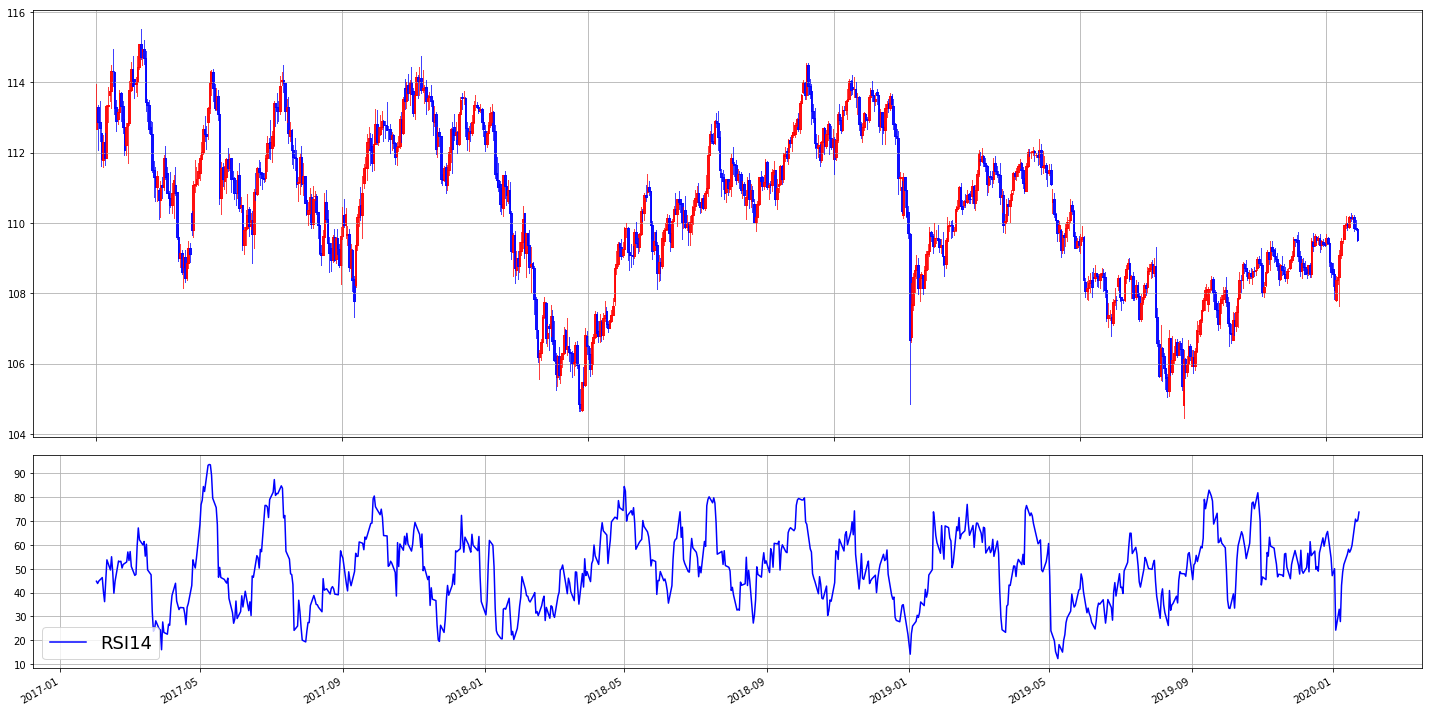

In [5]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

mpl_finance.candlestick2_ohlc(ax1,opens=df.open, highs=df.high, lows=df.low, closes=df.close, 
                              width=1,colorup='r', colordown='b')

xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both')
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
fig.tight_layout()

ax2.plot(df.time, df.rsi14, color='b', antialiased=True, label='RSI14')
ax2.grid(b=True, which='major', axis='both')

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()

# 4. Setting the objective variable<a id= 'Setting_the_objective_variable'></a>



**▼ target（%）**

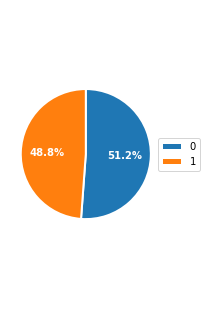

,target
0,394
1,376


In [6]:
# 翌日終値が当日終値よりも上昇するかを予測
df['t1_close'] = df.close.shift(-1)
df['t1_diff'] = df['t1_close'] - df['close']
df['target'] = np.where(df['t1_diff'] >= 0.01,1,0)

printmd('▼ target（%）')
per_state = round(df['target'].value_counts() / len(df['target']) * 100,2)
values = list(per_state.values)

# pie
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

display(pd.DataFrame(df['target'].value_counts(),columns=['target']))

# 5. Preprocessing<a id ='Preprocessing'></a>

In [7]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
end_row = df.shape[0]

# 翌日の予測用を保持
X_today_df = df.tail(1)

X_all_df = df.drop(['time','t1_close','t1_diff','target'], axis=1)

X_columns = X_all_df.columns

# 標準化項目リスト
enc_norm_col = ['open','high','low','close',
                'sma5','sma21','ema10',
                'rci9','rci21','rci52',
                'tilt_rci9','tilt_rci21','tilt_rci52',
                'tilt_sma5','tilt_sma21',
                'tilt_ema10',
                'rsi14',
                'tilt_rsi14',
                'bb1_up','bb1_low',
                'bb2_up','bb2_low',
                'bb3_up','bb3_low',
                'bb1_shrinkage','bb2_shrinkage','bb3_shrinkage',
                'momentum_5','momentum_10','momentum_21',
                'day_chg','c_all_len','c_pil_len','top_bar','low_bar',
                'y1_day_chg','y1_c_all_len','y1_c_pil_len','y1_top_bar','y1_low_bar',
                'y2_day_chg','y2_c_all_len','y2_c_pil_len','y2_top_bar','y2_low_bar',
                'y3_day_chg','y3_c_all_len','y3_c_pil_len','y3_top_bar','y3_low_bar',
                'y4_day_chg','y4_c_all_len','y4_c_pil_len','y4_top_bar','y4_low_bar',
                'y5_day_chg','y5_c_all_len','y5_c_pil_len','y5_top_bar','y5_low_bar',
               ]

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns

# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['target'].values

# 訓練用
X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

# テスト用
X_test = X_all[split_row+1:end_row-1,:]
y_test = y_all[split_row+1:end_row-1]

# 翌日の予測用
X_today = X_all[end_row - 1:,:]

# 標準化
for col_name,col_idx in dic_norm_col.items():
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    X_today[:,col_idx:col_idx+1] = stdsc.transform(X_today[:,col_idx:col_idx+1])
    

# 6.Modeling<a id='MOdeling'></a>

## 6-1. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],                  #distribution
              "n_estimators":[10],
              "min_samples_split": sp_randint(2, 3),
              "min_samples_leaf": sp_randint(1, 2),
              "criterion": ["gini"]}

forest_random = RandomizedSearchCV( estimator=RandomForestClassifier( random_state=1234 ),
                                    param_distributions=param_dist,
                                    cv=3,              #CV
                                    n_iter=1944,#interation num
                                    scoring="accuracy", #metrics
                                    n_jobs=1,           #num of core
                                    verbose=0,          
                                    random_state=1234)

forest_random.fit(X_train,y_train)
clf = forest_random.best_estimator_ #best estimator
print("Best Model Parameter: ",forest_random.best_params_)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X_columns).plot.bar(figsize=(40,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])
display(conf_mat)

printmd('▼ 閾値以上の信頼度でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = clf.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.60: # n%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] != -1]
display(b[['pred','actual','max_prob']].head(10))
print('正答率（※閾値指定）={:.3f}%'.format(accuracy_score(b['pred'], b['actual']) * 100))


test_csv = X_today_df
test_csv['tomorrow_pred'] = clf.predict(X_today)
test_csv['prob0'] = clf.predict_proba(X_today)[:,0]
test_csv['prob1'] = clf.predict_proba(X_today)[:,1]
test_csv = test_csv.reset_index()
test_csv = test_csv[['time','open','high','low','close','tomorrow_pred','prob0','prob1']]
display(test_csv)

print('Probability of rising the next day = {:.2f}%'.format(test_csv.iloc[0,7] * 100))

## 6-2. [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

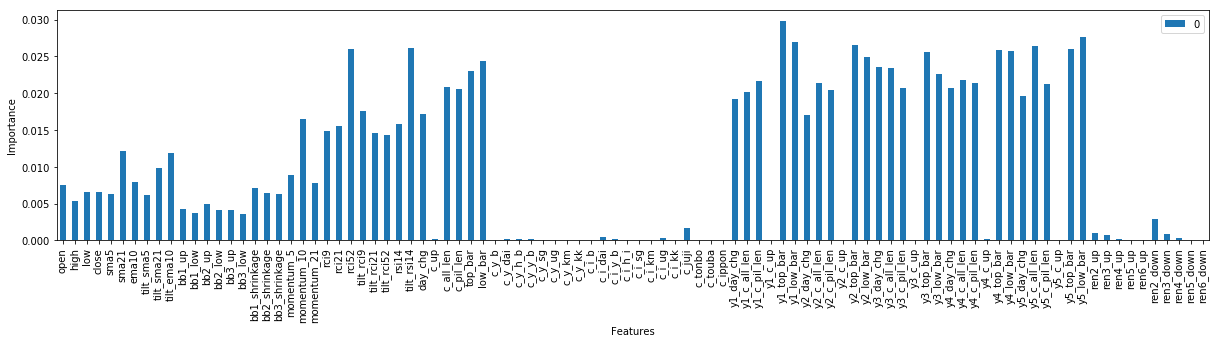



**▼ モデルの評価結果**

正答率（訓練データ） = 100.000%
正答率（テストデータ）= 55.263%
適合率（Precision※精度) = 59.259%
再現率（Recall※検出率) = 41.026%
F1値（F1-score） = 48.485%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,32,46
正解 =翌日上昇する,22,52




**▼ 閾値以上の信頼度でトレードした場合の勝率**

,pred,actual,max_prob
0,0,0,0.536844
1,0,0,0.644339
2,1,1,0.500760
3,0,1,0.572866
4,1,0,0.655056
5,0,1,0.771848
6,0,0,0.592882
7,0,0,0.619212
8,1,1,0.672292
9,1,1,0.735686


正答率（※閾値指定）=55.263%


,time,open,high,low,close,tomorrow_pred,prob0,prob1
0,2020-01-23,109.837,109.853,109.49,109.523,0,0.605537,0.394463


Probability of rising the next day = 39.45%


In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,min_samples_split=5,
                                                random_state=1234,criterion="gini"),
                         n_estimators=1000, random_state=1234)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X_columns).plot.bar(figsize=(40,4))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()


printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])
display(conf_mat)

printmd('▼ 閾値以上の信頼度でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = clf.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.50: # n%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] != -1]
display(b[['pred','actual','max_prob']].head(10))
print('正答率（※閾値指定）={:.3f}%'.format(accuracy_score(b['pred'], b['actual']) * 100))

test_csv = X_today_df
test_csv['tomorrow_pred'] = clf.predict(X_today)
test_csv['prob0'] = clf.predict_proba(X_today)[:,0]
test_csv['prob1'] = clf.predict_proba(X_today)[:,1]
test_csv = test_csv.reset_index()
test_csv = test_csv[['time','open','high','low','close','tomorrow_pred','prob0','prob1']]
display(test_csv)

print('Probability of rising the next day = {:.2f}%'.format(test_csv.iloc[0,7] * 100))